In [15]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold 
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
workload_data = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')

In [5]:
# Quick look at what we're working with
print(workload_data.head())


          gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

            gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
sample_0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
sample_1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
sample_2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
sample_3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
sample_4  0.360982     0.0     0.0  ...    5.996032    8.891425   10.373790   

          gene_20524  gene_20525  gene_20526  gene

Q1.1 Task 1:
- Are there missing values? Look on their website of the data to see how missing values are coded
Answer: It says on the website that the missing values are "N/A", but there aren't any (which can be seen in the code below)
- Compute the means and variances of the features (visualise in a histogram or with a kernel density estimate). Do they vary widely?
Answer: They do vary quite a lot yes, however they bot vary in mean quite normally, and for variance quite logarithmic.
- Are there constant features?
Answer: There are 267 columns with a variance of 0 and 14944 columns with a variance of less than 2.

In [6]:
contains_missing_values = workload_data.isna()
columns_with_missing_values = 0
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        columns_with_missing_values += 0
print(f'Amount of columns with missing values: {columns_with_missing_values}')
means = workload_data.mean()
variances = workload_data.var()
n_of_constant_values = variances[variances == 0]
n_of_low_var_values = variances[variances < 2]
print(f'Number of columns with variance = 0: {len(n_of_constant_values)} st')
print(f'Number of columns with variance < 2: {len(n_of_low_var_values)} st')
print(f'There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset')

Amount of columns with missing values: 0
Number of columns with variance = 0: 267 st
Number of columns with variance < 2: 14944 st
There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset


In [7]:
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        print(f'{column_name=}')
print(f'No missing values, all gene_values are numeric values')
means = workload_data.mean()
variances = workload_data.var()
variance_threshold = 2
n_of_constant_values = variances[variances < variance_threshold]
print(f'Number of columns with variance < 2: {len(n_of_constant_values)} st')
print(f'There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset')

No missing values, all gene_values are numeric values
Number of columns with variance < 2: 14944 st
There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset


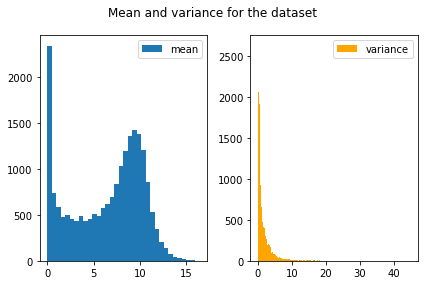

They do vary quite widely yes


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do vary quite widely yes')

Q1.1 Task 2:

In [9]:
trimmed_data = workload_data.copy()
data_columns = trimmed_data.columns
selector = VarianceThreshold(threshold=variance_threshold)

# rename them with same index and column names
columns_data = [f'gene_{i}' for i in range(1, 5580)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
trimmed_data = pd.DataFrame(selector.fit_transform(trimmed_data), columns=columns_data, index=rows_data)

        

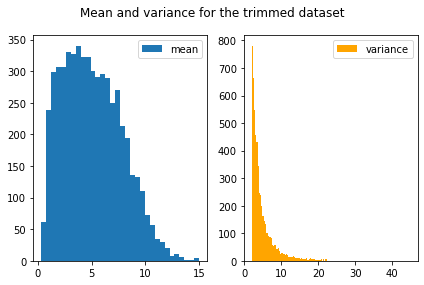

They do look alot better right now, gaussian and logarithmic


In [10]:
means = trimmed_data.mean()
variances = trimmed_data.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look alot better right now, gaussian and logarithmic')

-5.030693687977732e-17 0.9993755853277826


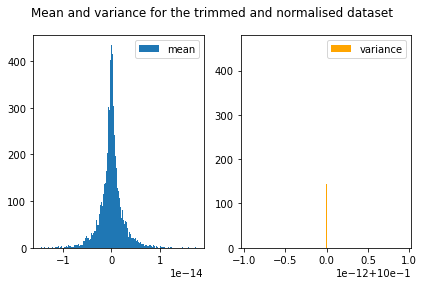

They do look very much "normalised", guess we will keep both and check


In [13]:
# Plot a normalised version to check if needed
normalized_df=(trimmed_data-trimmed_data.mean())/trimmed_data.std()
# Just checking it works
print(np.mean(np.mean(normalized_df)), np.mean(np.std(normalized_df)))
means = normalized_df.mean()
variances = normalized_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look very much "normalised", guess we will keep both and check')


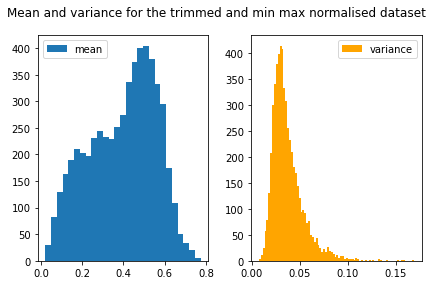

The min max version looks very similar to the original


In [12]:

min_max_df=(trimmed_data-trimmed_data.min())/(trimmed_data.max()-trimmed_data.min())

means = min_max_df.mean()
variances = min_max_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and min max normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'The min max version looks very similar to the original, might be an indication its not really needed')

In [65]:
n_components = 5
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)
print(principalComponents.shape)

(801, 5)


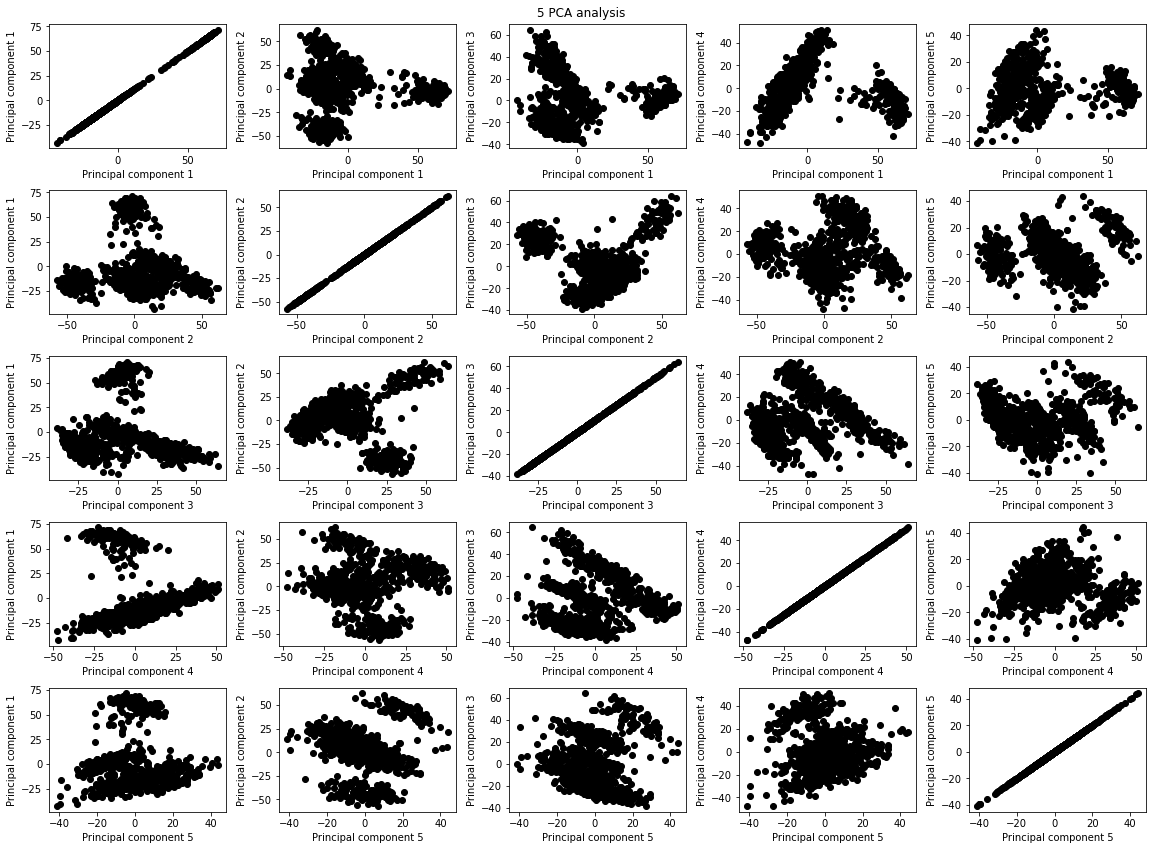

Here we can see that there are some clustered areas, however there is hard to see a cluster count from here


In [67]:

fig = plt.figure(figsize=(16,12))
plt.suptitle(f'{n_components} PCA analysis')
axes = fig.subplots(nrows=n_components, ncols=n_components)
for x_index in range(n_components):
    for y_index in range(n_components):
        
        axes[x_index, y_index].scatter(principalComponents[:,x_index], principalComponents[:,y_index], color='Black')
        axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}')
        axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}')
plt.tight_layout()
plt.show()
print('Here we can see that there are some clustered areas, however there is hard to see a cluster count from here')

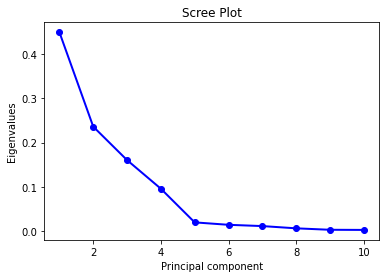

Not really sure what we're suppose to conclude here, HELP FREDRIK


In [64]:
# Doing the scree plot for 10 values 
n_components = 10
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)

PC_values = np.arange(pca.n_components) + 1
N = np.matrix(principalComponents.T)*np.matrix(principalComponents)
A, B, C = np.linalg.svd(N)
eigen_values = B**2/(np.sum(B**2))
plt.plot(PC_values, eigen_values, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()
print("Not really sure what we're suppose to conclude here, HELP FREDRIK")